+ 데이터 전처리 : R의 {caret} 패키지(단, 모든 데이터는 수치형으로 가정)

### 2.2.1 영-과 영근처-분산 예측변수의 처리
+ 예제 1.

In [1]:
install.packages("caret")
library(caret)
data(mdrr)
data.frame(table(mdrrDescr$nR11))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice



Var1,Freq
<fct>,<int>
0,501
1,4
2,23


+ 다중약물내성 자료(528개 관측치, 342개 변수)
+ 데이터가 매우 불균형 & 몇 개의 수치만을 취함
+ 이러한 예측변수의 문제점 : 교차타당성/붓스트랩 하위 샘플로 분할될 때 영-분산 예측변수가 되거나, 일부 샘플이 모형에 과도한 영향을 미침

  → 모형화 이전에 식별되고 제거 필요
+ 영-분산 예측변수 식별 측도 : 아래의 두 기준을 모두 사용하면 위험성을 줄일 수 있음
  1) 빈도비율 : (일순위 빈발값의 빈도) / (차순위 빈발값의 빈도)
  + 정상적 - 1에 가까움, 불균형 - 매우 큰 값
  + 현재 data : 501 / 23
  
  2) 유일 값들의 비율 : (유일한 값들의 수) / (전체 표본의 수) * 100
  + 집중도 클수록 0에 가까움
  + 현재 data : (1) 501 / 528 * 100   (2) 4 / 528 * 100   (3) 23 / 528 * 100

In [2]:
nzv = nearZeroVar(mdrrDescr, saveMetrics = TRUE)
str(nzv)

'data.frame':	342 obs. of  4 variables:
 $ freqRatio    : num  1.25 1.12 1 1.25 1.25 ...
 $ percentUnique: num  90 42.6 83 84.3 82.8 ...
 $ zeroVar      : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ nzv          : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...


In [3]:
nzv[nzv$nzv, ][1:10, ]  # nzv의 nzv 변수를 가져와서 처음 10개만 출력

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
nTB,23.00000,0.3787879,FALSE,TRUE
nBR,131.00000,0.3787879,FALSE,TRUE
nI,527.00000,0.3787879,FALSE,TRUE
nR03,527.00000,0.3787879,FALSE,TRUE
nR08,527.00000,0.3787879,FALSE,TRUE
nR11,21.78261,0.5681818,FALSE,TRUE
nR12,57.66667,0.3787879,FALSE,TRUE
D.Dr03,527.00000,0.3787879,FALSE,TRUE
D.Dr07,123.50000,5.8712121,FALSE,TRUE


In [4]:
dim(mdrrDescr)

[1] 528 342

In [5]:
nzv = nearZeroVar(mdrrDescr)
nzv

[1]  22  31  32  34  38  41  42 259 262 263 264 266 267 270 271 272 273 274 276
[20] 277 278 279 280 281 282 283 284 285 286 287 288 327 328 330 331 333 334 335
[39] 336 337 338 339 340 341 342

In [6]:
filteredDescr = mdrrDescr[, -nzv]  # 영근처- 분산을 가지는 변수 제거
dim(filteredDescr)  # (342 - 297)개 삭제

[1] 528 297

+ nearZeroVar() 함수 : 영근처-분산의 변수 식별, 문제가 되는 변수의 위치를 반환
  + 디폴트 : 표본에서 유일 값의 비율이 10% 이하이고 빈도비율이 19(95/5)보다 큰 예측변수는 영-근처 분산으로 분류됨

### 2.2.2 상관된 예측변수의 식별 : 중복변수 제거
+ 다중공선성의 영향을 고려하여 예측변수들 간의 상관관계의 수준은 줄이는 것이 좋다.
+ 예제 2.

In [7]:
descrCor = cor(filteredDescr)

In [8]:
# sum : 논리형 자료의 합
highCorr = sum(abs(descrCor[upper.tri(descrCor)]) > .999)

+ 상관계수가 0.999 이상인 경우가 65개임

In [9]:
summary(descrCor[upper.tri(descrCor)])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99607 -0.05373  0.25006  0.26078  0.65527  1.00000 

In [10]:
# 0.75 이상의 절대 상관계수를 갖는 예측변수를 제거하는 과정과 그 효과
highlyCorDescr = findCorrelation(descrCor, cutoff = 0.75)  # 기준 완화
filteredDescr = filteredDescr[, -highlyCorDescr]
descrCor2 = cor(filteredDescr)
summary(descrCor2[upper.tri(descrCor2)])
# findCorrelation() 함수 : 제거해야할 예측변수를 제공함

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.70728 -0.05378  0.04418  0.06692  0.18858  0.74458 

### 2.2.3 예측변수의 변환
#### (a) 중심화와 척도화
+ preProcess() 함수 : 예측변수에 중심화와 척도화를 포함한 많은 연산 제공
  + 이는 특정한 데이터 셋으로부터 요구하는 것을 추저한 다음, 이 값을 재계산하지 않고 임의의 데이터 셋에 이들 변환을 적용
  
+ 예제 3.

In [11]:
set.seed(200)
# 1부터 mdrrClass의 길이만큼 생성 -> 1:528
inTrain = sample(seq(along = mdrrClass), length(mdrrClass) / 2)
training = filteredDescr[inTrain, ]
test = filteredDescr[-inTrain, ]
trainMDRR = mdrrClass[inTrain]
testMDRR = mdrrClass[-inTrain]

In [12]:
# 중심화와 척도화
preProcValues = preProcess(training, method = c("center", "scale"))
trainTransformed = predict(preProcValues, training)
testTransformed = predict(preProcValues, test)

+ 1) 원자료에서 train 50(or 70) : 모형구축 + test 50(or 30) : 모형성능평가
+ 2) 원자료에서 train 40 : 모형구축 + validation 30 : 구축된 모형의 성능 향상(개선, 타당성 검증) + test 30 : 모형 성능 평가

#### (b) 박스-콕스 변환

In [13]:
# 박스-콕스 변환 수행 : method = "BoxCox"
preProcValues2 = preProcess(training, method = "BoxCox")
trainBC = predict(preProcValues2, training)
testBC = predict(preProcValues2, test)
preProcValues2

Created from 264 samples and 31 variables

Pre-processing:
  - Box-Cox transformation (31)
  - ignored (0)

Lambda estimates for Box-Cox transformation:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.0000 -0.2500  0.4000  0.4548  1.4500  2.0000 


### 2.2.4* 기타 전처리 방법
#### (a) 범주형 변수에 대한 더미변수 생성
+ dummyVars() 함수 : 하나 이상의 요인으로부터 완전한 더미변수 집합을 생성
+ 예제 5.

In [14]:
install.packages("earth")
library(earth)
data(etitanic)
str(etitanic)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plotrix’, ‘Formula’, ‘plotmo’, ‘TeachingDemos’


Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix

Loading required package: TeachingDemos



'data.frame':	1046 obs. of  6 variables:
 $ pclass  : Factor w/ 3 levels "1st","2nd","3rd": 1 1 1 1 1 1 1 1 1 1 ...
 $ survived: int  1 1 0 0 0 1 1 0 1 0 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 1 2 1 2 1 2 1 2 ...
 $ age     : num  29 0.917 2 30 25 ...
 $ sibsp   : int  0 1 1 1 1 0 1 0 2 0 ...
 $ parch   : int  0 2 2 2 2 0 0 0 0 0 ...


In [15]:
# model.matrix{stats} 함수 : (범주의 수 - 1)개 생성 -> 공선성 방지
# pclass : 2개 + sex : 1개
head(model.matrix(survived ~ ., data = etitanic))

,(Intercept),pclass2nd,pclass3rd,sexmale,age,sibsp,parch
1,1,0,0,0,29.0000,0,0
2,1,0,0,1,0.9167,1,2
3,1,0,0,0,2.0000,1,2
4,1,0,0,1,30.0000,1,2
5,1,0,0,0,25.0000,1,2
6,1,0,0,1,48.0000,0,0


In [16]:
# dummyVar() 함수 : 범주의 수만큼 생성 -> 딥러닝 / 신경망에서 많이 씀 -> 역행렬 계산 시 오류x
# pclass : 3개 + sex : 2개
dummy.1 = dummyVars(survived ~ ., data = etitanic)
head(predict(dummy.1, newdata = etitanic))

,pclass.1st,pclass.2nd,pclass.3rd,sex.female,sex.male,age,sibsp,parch
1,1,0,0,1,0,29.0000,0,0
2,1,0,0,0,1,0.9167,1,2
3,1,0,0,1,0,2.0000,1,2
4,1,0,0,0,1,30.0000,1,2
5,1,0,0,1,0,25.0000,1,2
6,1,0,0,0,1,48.0000,0,0


+ 새로 생성된 더미변수는 일부 모형 함수 계산 시 오류가 발생할 수 있음

#### (b) 선형종속성
+ findLinearCombos() 함수 : 행렬의 QR 분해를 사용하여 선형 결합의 집합을 열거
  + 선형종속성을 없애기 위해 제거할 열 위치의 벡터를 제공
+ 예제 6.

In [17]:
ltfrDesign = matrix(0, nrow = 6, ncol = 6)
ltfrDesign[, 1] = c(1, 1, 1, 1, 1, 1)
ltfrDesign[, 2] = c(1, 1, 1, 0, 0, 0)
ltfrDesign[, 3] = c(0, 0, 0, 1, 1, 1)
ltfrDesign[, 4] = c(1, 0, 0, 1, 0, 0)
ltfrDesign[, 5] = c(0, 1, 0, 0, 1, 0)
ltfrDesign[, 6] = c(0, 0, 1, 0, 0, 1)

comboInfo = findLinearCombos(ltfrDesign)
# 3번째 변수는 1, 2의 선형결합으로 만들어진다
# 6번째 변수는 1, 4, 5의 선형결합으로 만들어진다
# 3, 6을 제거하면 선형종속의 문제가 사라진다
comboInfo
ltfrDesign[, -comboInfo$remove]

$linearCombos
$linearCombos[[1]]
[1] 3 1 2

$linearCombos[[2]]
[1] 6 1 4 5


$remove
[1] 3 6

1,1,1,0
1,1,0,1
1,1,0,0
1,0,1,0
1,0,0,1
1,0,0,0


+ 2열 + 3열 = 1열 / 4열 + 5열 + 6열 = 1열 : 선형종속적



#### (c) 결측값 대치
+ k-근접 이웃(KNN) 이용
+ 예제 7.

In [18]:
data(airquality)
summary(airquality)  # 결측값 개수 확인

     Ozone           Solar.R           Wind             Temp      
 Min.   :  1.00   Min.   :  7.0   Min.   : 1.700   Min.   :56.00  
 1st Qu.: 18.00   1st Qu.:115.8   1st Qu.: 7.400   1st Qu.:72.00  
 Median : 31.50   Median :205.0   Median : 9.700   Median :79.00  
 Mean   : 42.13   Mean   :185.9   Mean   : 9.958   Mean   :77.88  
 3rd Qu.: 63.25   3rd Qu.:258.8   3rd Qu.:11.500   3rd Qu.:85.00  
 Max.   :168.00   Max.   :334.0   Max.   :20.700   Max.   :97.00  
 NA's   :37       NA's   :7                                       
     Month            Day      
 Min.   :5.000   Min.   : 1.0  
 1st Qu.:6.000   1st Qu.: 8.0  
 Median :7.000   Median :16.0  
 Mean   :6.993   Mean   :15.8  
 3rd Qu.:8.000   3rd Qu.:23.0  
 Max.   :9.000   Max.   :31.0  
                               

In [19]:
imp.1 = preProcess(airquality, method = c("knnImpute"))
install.packages("RANN")
library(RANN)
imp.2 = predict(imp.1, airquality)  # predict() : 대치된 값 확인
summary(airquality)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



     Ozone           Solar.R           Wind             Temp      
 Min.   :  1.00   Min.   :  7.0   Min.   : 1.700   Min.   :56.00  
 1st Qu.: 18.00   1st Qu.:115.8   1st Qu.: 7.400   1st Qu.:72.00  
 Median : 31.50   Median :205.0   Median : 9.700   Median :79.00  
 Mean   : 42.13   Mean   :185.9   Mean   : 9.958   Mean   :77.88  
 3rd Qu.: 63.25   3rd Qu.:258.8   3rd Qu.:11.500   3rd Qu.:85.00  
 Max.   :168.00   Max.   :334.0   Max.   :20.700   Max.   :97.00  
 NA's   :37       NA's   :7                                       
     Month            Day      
 Min.   :5.000   Min.   : 1.0  
 1st Qu.:6.000   1st Qu.: 8.0  
 Median :7.000   Median :16.0  
 Mean   :6.993   Mean   :15.8  
 3rd Qu.:8.000   3rd Qu.:23.0  
 Max.   :9.000   Max.   :31.0  
                               

#### (d) 군집거리 계산
+ 각 군집중심까지의 마할라노비스 거리가 계산
+ classDist() 함수 : 군집 내에서 주성분분석 수행하여 공분산행렬 문제 해결
+ predict.classDist() 함수 : 군집거리 생성하는 데 사용
+ 예제 8.

In [20]:
# 훈련용자료로부터 군집중심과 공분산행렬 계산
trainSet = sample(1:150, 100)
distData = classDist(iris[trainSet, 1:4], iris$Species[trainSet])
distData$values

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,20.2608477,-13.658011,-7.699669,-0.7552542
Sepal.Width,-13.6580115,17.586335,4.274466,-8.9586461
Petal.Length,-7.6996694,4.274466,32.654508,-16.0113441
Petal.Width,-0.7552542,-8.958646,-16.011344,99.3825581
,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,12.388139,-2.185631,-8.637163,3.528737
Sepal.Width,-2.185631,20.195145,1.031926,-15.217328
Petal.Length,-8.637163,1.031926,21.414366,-36.108266
Petal.Width,3.528737,-15.217328,-36.108266,113.155926
,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width


In [21]:
# 제외된(검증용) 자료에 대해 군집중심까지의 마할라노비스 거리 계산
newDist = predict(distData, iris[-trainSet, 1:4])
newDist

,dist.setosa,dist.versicolor,dist.virginica
1,-0.519901195,4.5717425,5.20335944
2,1.007168029,4.2081656,5.08395902
15,2.459942067,5.0651726,5.55830921
18,-0.119479566,4.4931370,5.16985682
19,1.685006934,4.7389994,5.27450103
20,0.290483717,4.6627160,5.17595398
22,0.826596195,4.5291732,5.12295943
27,0.930639856,4.2569461,4.99740588
28,0.004583052,4.5693658,5.19178910
29,0.628610532,4.5314912,5.22198927


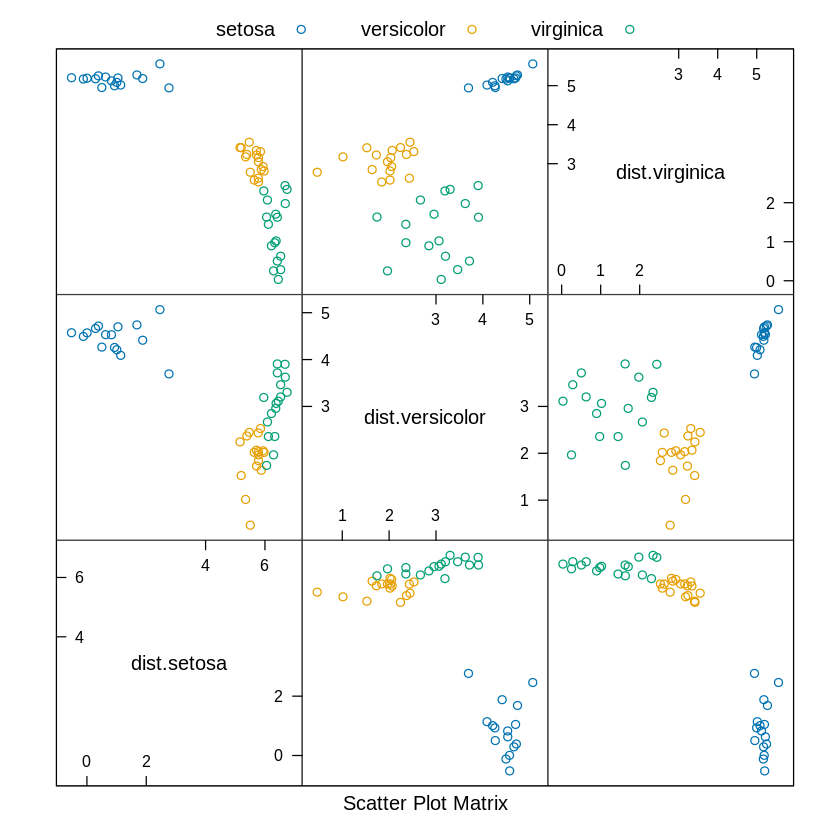

In [22]:
# 제외된 자료에 대한 군집거리의 산점도행렬
splom(newDist, groups = iris$Species[-trainSet], auto.key = list(columns = 3))